In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
%matplotlib inline

In [117]:
train = pd.read_csv("../../input/train.csv")
test = pd.read_csv("../../input/test.csv")

In [118]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

## Imputation of missing values ##

In [119]:
# I have no idea how to do it better. Probably, it is better to do nothing
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
# plt.scatter(x, y)
t = (x <= 25000) & (y <= 150)
p = np.polyfit(x[t], y[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

There are many features were NaN should be considered as absence of such property. In other cases I replace NaN with most common value

In [120]:
all_data.loc[all_data.Alley.isnull(), 'Alley'] = 'NoAlley'
all_data.loc[all_data.MasVnrType.isnull(), 'MasVnrType'] = 'None' # no good
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0
all_data.loc[all_data.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
all_data.loc[all_data.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
all_data.loc[all_data.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
all_data.loc[all_data.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'
all_data.loc[all_data.GarageType.isnull(), 'GarageType'] = 'NoGarage'
all_data.loc[all_data.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
all_data.loc[all_data.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
all_data.loc[all_data.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
all_data.loc[all_data.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
all_data.loc[all_data.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0
all_data.loc[all_data.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
all_data.loc[all_data.MSZoning.isnull(), 'MSZoning'] = 'RL'
all_data.loc[all_data.Utilities.isnull(), 'Utilities'] = 'AllPub'
all_data.loc[all_data.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
all_data.loc[all_data.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
all_data.loc[all_data.Functional.isnull(), 'Functional'] = 'Typ'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
all_data.loc[all_data['Fence'].isnull(), 'Fence'] = 'NoFence'
all_data.loc[all_data['MiscFeature'].isnull(), 'MiscFeature'] = 'None'
all_data.loc[all_data['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

## Normalization ##

In [121]:
# where we have order we will use numeric
all_data = all_data.replace({'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0},
                             'Street': {'Pave': 1, 'Grvl': 0 },
                             'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0 
                                            },
                             'Fence': {'GdPrv': 2, 
                                       'GdWo': 2, 
                                       'MnPrv': 1, 
                                       'MnWw': 1,
                                       'NoFence': 0},
                             'ExterQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'ExterCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3, 
                                            'Av': 2, 
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'GarageQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6}                             
                            })

In [122]:
newer_dwelling = all_data.MSSubClass.replace({20: 1, 
                                            30: 0, 
                                            40: 0, 
                                            45: 0,
                                            50: 0, 
                                            60: 1,
                                            70: 0,
                                            75: 0,
                                            80: 0,
                                            85: 0,
                                            90: 0,
                                           120: 1,
                                           150: 0,
                                           160: 0,
                                           180: 0,
                                           190: 0})
newer_dwelling.name = 'newer_dwelling'

In [123]:
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

In [124]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,SubClass_60,RL,65.000000,8450,1,NoAlley,Reg,Lvl,1,Inside,...,0,0,NoPool,0,None,0,2,2008,WD,Normal
1,SubClass_20,RL,80.000000,9600,1,NoAlley,Reg,Lvl,1,FR2,...,0,0,NoPool,0,None,0,5,2007,WD,Normal
2,SubClass_60,RL,68.000000,11250,1,NoAlley,IR1,Lvl,1,Inside,...,0,0,NoPool,0,None,0,9,2008,WD,Normal
3,SubClass_70,RL,60.000000,9550,1,NoAlley,IR1,Lvl,1,Corner,...,0,0,NoPool,0,None,0,2,2006,WD,Abnorml
4,SubClass_60,RL,84.000000,14260,1,NoAlley,IR1,Lvl,1,FR2,...,0,0,NoPool,0,None,0,12,2008,WD,Normal
5,SubClass_50,RL,85.000000,14115,1,NoAlley,IR1,Lvl,1,Inside,...,0,0,NoPool,1,Shed,700,10,2009,WD,Normal
6,SubClass_20,RL,75.000000,10084,1,NoAlley,Reg,Lvl,1,Inside,...,0,0,NoPool,0,None,0,8,2007,WD,Normal
7,SubClass_60,RL,72.765958,10382,1,NoAlley,IR1,Lvl,1,Corner,...,0,0,NoPool,0,Shed,350,11,2009,WD,Normal
8,SubClass_50,RM,51.000000,6120,1,NoAlley,Reg,Lvl,1,Inside,...,0,0,NoPool,0,None,0,4,2008,WD,Abnorml
9,SubClass_190,RL,50.000000,7420,1,NoAlley,Reg,Lvl,1,Corner,...,0,0,NoPool,0,None,0,1,2008,WD,Normal


In [125]:
# The idea is good quality should rise price, poor quality - reduce price
overall_poor_qu = all_data.OverallQual.copy()
overall_poor_qu = 5 - overall_poor_qu
overall_poor_qu[overall_poor_qu<0] = 0
overall_poor_qu.name = 'overall_poor_qu'

overall_good_qu = all_data.OverallQual.copy()
overall_good_qu = overall_good_qu - 5
overall_good_qu[overall_good_qu<0] = 0
overall_good_qu.name = 'overall_good_qu'

overall_poor_cond = all_data.OverallCond.copy()
overall_poor_cond = 5 - overall_poor_cond
overall_poor_cond[overall_poor_cond<0] = 0
overall_poor_cond.name = 'overall_poor_cond'

overall_good_cond = all_data.OverallCond.copy()
overall_good_cond = overall_good_cond - 5
overall_good_cond[overall_good_cond<0] = 0
overall_good_cond.name = 'overall_good_cond'

exter_poor_qu = all_data.ExterQual.copy()
exter_poor_qu[exter_poor_qu<3] = 1
exter_poor_qu[exter_poor_qu>=3] = 0
exter_poor_qu.name = 'exter_poor_qu'

exter_good_qu = all_data.ExterQual.copy()
exter_good_qu[exter_good_qu<=3] = 0
exter_good_qu[exter_good_qu>3] = 1
exter_good_qu.name = 'exter_good_qu'

exter_poor_cond = all_data.ExterCond.copy()
exter_poor_cond[exter_poor_cond<3] = 1
exter_poor_cond[exter_poor_cond>=3] = 0
exter_poor_cond.name = 'exter_poor_cond'

exter_good_cond = all_data.ExterCond.copy()
exter_good_cond[exter_good_cond<=3] = 0
exter_good_cond[exter_good_cond>3] = 1
exter_good_cond.name = 'exter_good_cond'

bsmt_poor_cond = all_data.BsmtCond.copy()
bsmt_poor_cond[bsmt_poor_cond<3] = 1
bsmt_poor_cond[bsmt_poor_cond>=3] = 0
bsmt_poor_cond.name = 'bsmt_poor_cond'

bsmt_good_cond = all_data.BsmtCond.copy()
bsmt_good_cond[bsmt_good_cond<=3] = 0
bsmt_good_cond[bsmt_good_cond>3] = 1
bsmt_good_cond.name = 'bsmt_good_cond'

garage_poor_qu = all_data.GarageQual.copy()
garage_poor_qu[garage_poor_qu<3] = 1
garage_poor_qu[garage_poor_qu>=3] = 0
garage_poor_qu.name = 'garage_poor_qu'

garage_good_qu = all_data.GarageQual.copy()
garage_good_qu[garage_good_qu<=3] = 0
garage_good_qu[garage_good_qu>3] = 1
garage_good_qu.name = 'garage_good_qu'

garage_poor_cond = all_data.GarageCond.copy()
garage_poor_cond[garage_poor_cond<3] = 1
garage_poor_cond[garage_poor_cond>=3] = 0
garage_poor_cond.name = 'garage_poor_cond'

garage_good_cond = all_data.GarageCond.copy()
garage_good_cond[garage_good_cond<=3] = 0
garage_good_cond[garage_good_cond>3] = 1
garage_good_cond.name = 'garage_good_cond'

kitchen_poor_qu = all_data.KitchenQual.copy()
kitchen_poor_qu[kitchen_poor_qu<3] = 1
kitchen_poor_qu[kitchen_poor_qu>=3] = 0
kitchen_poor_qu.name = 'kitchen_poor_qu'

kitchen_good_qu = all_data.KitchenQual.copy()
kitchen_good_qu[kitchen_good_qu<=3] = 0
kitchen_good_qu[kitchen_good_qu>3] = 1
kitchen_good_qu.name = 'kitchen_good_qu'

qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,
                     exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,
                     garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)

bad_heating = all_data.HeatingQC.replace({'Ex': 0, 
                                          'Gd': 0, 
                                          'TA': 0, 
                                          'Fa': 1,
                                          'Po': 1})
bad_heating.name = 'bad_heating'
                                          
MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,
                                                          'Alloca': 1,
                                                          'AdjLand': 1,
                                                          'Family': 1,
                                                          'Normal': 0,
                                                          'Partial': 0})
SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'

Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])
Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1
Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1
Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1
Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1
Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1

# do smth with BsmtFinType1, BsmtFinType2

I have no idea what to do with Exterior1st, Exterior2nd, RoofMatl, Condition1, Condition2, BldgType. I'll try convert them into some kind of price brackets

In [126]:
pc_pred

array(['pc3', 'pc1', 'pc3', ..., 'pc3', 'pc1', 'pc2'], dtype=object)

In [127]:
from sklearn.svm import SVC
svm = SVC(C=100)
# price categories
pc = pd.Series(np.zeros(train.shape[0]))
pc[:] = 'pc1'
pc[train.SalePrice >= 150000] = 'pc2'
pc[train.SalePrice >= 220000] = 'pc3'
columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
X_t = pd.get_dummies(train.loc[:, columns_for_pc], sparse=True)
svm.fit(X_t, pc)
pc_pred = svm.predict(X_t)

(array([  13.,  125.,  183.,   94.,   40.,   16.,    3.,    3.,    1.,    2.]),
 array([ 0.379 ,  1.0961,  1.8132,  2.5303,  3.2474,  3.9645,  4.6816,
         5.3987,  6.1158,  6.8329,  7.55  ]),
 <a list of 10 Patch objects>)

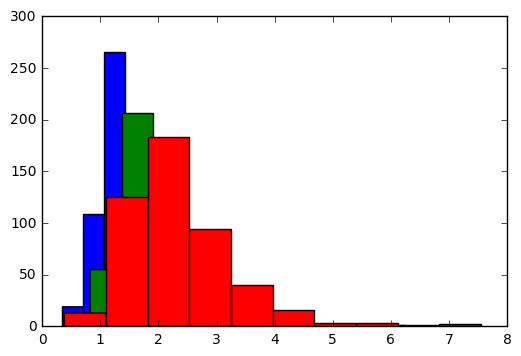

In [128]:
p = train.SalePrice/100000
plt.hist(p[pc_pred=='pc1'])
plt.hist(p[pc_pred=='pc2'])
plt.hist(p[pc_pred=='pc3'])

In [129]:
price_category = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['pc'])
X_t = pd.get_dummies(all_data.loc[:, columns_for_pc], sparse=True)
pc_pred = svm.predict(X_t)
price_category[pc_pred=='pc2'] = 1
price_category[pc_pred=='pc3'] = 2
price_category = price_category.to_sparse()

In [130]:
type(price_category)

pandas.sparse.frame.SparseDataFrame

In [131]:
# Monthes with the lagest number of deals may be significant
season = all_data.MoSold.replace( {1: 0, 
                                   2: 0, 
                                   3: 0, 
                                   4: 1,
                                   5: 1, 
                                   6: 1,
                                   7: 1,
                                   8: 0,
                                   9: 0,
                                  10: 0,
                                  11: 0,
                                  12: 0})
season.name = 'season'

# Numer month is not significant
all_data = all_data.replace({'MoSold': {1: 'Yan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})

In [132]:
all_data = all_data.replace({'CentralAir': {'Y': 1, 
                                            'N': 0}})
all_data = all_data.replace({'PavedDrive': {'Y': 1, 
                                            'P': 0,
                                            'N': 0}})

In [133]:
reconstruct = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Reconstruct'])
reconstruct[all_data.YrSold < all_data.YearRemodAdd] = 1
reconstruct = reconstruct.to_sparse()

recon_after_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['ReconstructAfterBuy'])
recon_after_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1
recon_after_buy = recon_after_buy.to_sparse()

build_eq_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Build.eq.Buy'])
build_eq_buy[all_data.YearBuilt >= all_data.YrSold] = 1
build_eq_buy = build_eq_buy.to_sparse()

In [134]:
# I hope this will help
all_data.YrSold = 2010 - all_data.YrSold

In [135]:
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'

In [136]:
all_data.YearBuilt = all_data.YearBuilt.map(year_map)
all_data.YearRemodAdd = all_data.YearRemodAdd.map(year_map)

Scaling numeric data

In [137]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

t = all_data[numeric_feats].quantile(.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
all_data[use_max_scater] = all_data[use_max_scater]/all_data[use_max_scater].max()
all_data[use_95_scater] = all_data[use_95_scater]/all_data[use_95_scater].quantile(.95)

In [138]:
t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

all_data.loc[:, t] = np.log1p(all_data.loc[:, t])

In [139]:
X

,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,BsmtUnfSF_GarageQual,BsmtUnfSF_GarageCond,BsmtUnfSF_KitchenQual,BsmtUnfSF_HeatingQC,BsmtUnfSF_bad_heating,BsmtUnfSF_MasVnrType_Any,BsmtUnfSF_SaleCondition_PriceDown,BsmtUnfSF_Reconstruct,BsmtUnfSF_ReconstructAfterBuy,BsmtUnfSF_Build.eq.Buy
0,0.465314,0.400731,1.0,1.0,0.875,0.625,0.998007,0.998007,0.351080,1.00,...,0.096875,0.096875,0.077500,0.096875,0.000000,0.096875,0.096875,0.0,0.000000,0.0
1,0.547686,0.444685,1.0,1.0,0.750,1.000,0.984554,0.984554,0.000000,0.75,...,0.176131,0.176131,0.105679,0.176131,0.000000,0.000000,0.176131,0.0,0.000000,0.0
2,0.482340,0.504555,1.0,1.0,0.875,0.625,0.997010,0.997509,0.298355,1.00,...,0.257983,0.257983,0.206387,0.257983,0.000000,0.257983,0.257983,0.0,0.000000,0.0
3,0.436276,0.442814,1.0,1.0,0.875,0.625,0.954160,0.981565,0.000000,0.75,...,0.312034,0.312034,0.249627,0.312034,0.000000,0.000000,0.312034,0.0,0.000000,0.0
4,0.568553,0.605316,1.0,1.0,1.000,0.625,0.996512,0.996512,0.560229,1.00,...,0.286902,0.286902,0.229522,0.286902,0.000000,0.286902,0.286902,0.0,0.000000,0.0
5,0.573702,0.600688,1.0,1.0,0.625,0.625,0.993024,0.994021,0.000000,0.75,...,0.042486,0.042486,0.025492,0.042486,0.000000,0.000000,0.042486,0.0,0.000000,0.0
6,0.520976,0.462621,1.0,1.0,1.000,0.625,0.998505,0.999003,0.335859,1.00,...,0.194722,0.194722,0.155778,0.194722,0.000000,0.194722,0.194722,0.0,0.000000,0.0
7,0.508807,0.473507,1.0,1.0,0.875,0.750,0.983059,0.983059,0.415430,0.75,...,0.136697,0.136697,0.082018,0.136697,0.000000,0.136697,0.136697,0.0,0.000000,0.0
8,0.381784,0.305276,1.0,1.0,0.875,0.625,0.962133,0.971599,0.000000,0.75,...,0.332070,0.498104,0.298863,0.498104,0.000000,0.000000,0.498104,0.0,0.000000,0.0
9,0.375542,0.359653,1.0,1.0,0.625,0.750,0.966119,0.971599,0.000000,0.75,...,0.120934,0.090700,0.054420,0.090700,0.000000,0.000000,0.090700,0.0,0.000000,0.0


## Preparing for sklearn##

In [140]:
# all classes in sklearn requires numeric data only
# transform categorical variable into binary
X = pd.get_dummies(all_data, sparse=True)
X = X.fillna(0)

In [141]:
X = X.drop('RoofMatl_ClyTile', axis=1) # only one is not zero
X = X.drop('Condition2_PosN', axis=1) # only two is not zero
X = X.drop('MSZoning_C (all)', axis=1)
X = X.drop('MSSubClass_SubClass_160', axis=1)
# this features definitely couse overfitting

In [142]:
# add new features
X = pd.concat((X, newer_dwelling, season, reconstruct, recon_after_buy,
               qu_list, bad_heating, MasVnrType_Any, price_category, build_eq_buy), axis=1)

Next step is guess what new feachers we need to intoduse to make the model better. I'll make a lot of feachers and model wiil choose

In [143]:
from itertools import product, chain

def poly(X):
    areas = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']
    # t = [s for s in X.axes[1].get_values() if s not in areas]
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',
               'KitchenQual', 'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x

XP = pd.concat(poly(X), axis=1)
X = pd.concat((X, XP), axis=1)

In [144]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [145]:
# the model has become really big
X_train.shape

(1460, 466)

In [147]:
y = np.log1p(train.SalePrice)

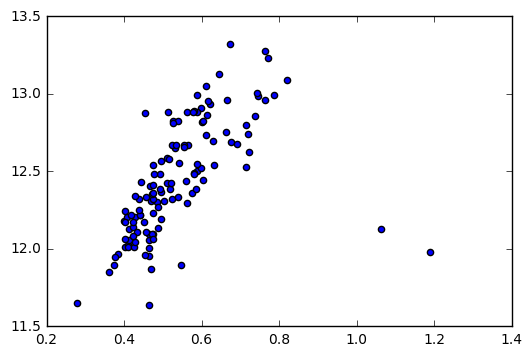

In [148]:
# this come from iterational model improvment. I was trying to understand why the model gives to the two points much better price
x_plot = X_train.loc[X_train['SaleCondition_Partial']==1, 'GrLivArea']
y_plot = y[X_train['SaleCondition_Partial']==1]
plt.scatter(x_plot, y_plot)

In [29]:
outliers_id = np.array([524, 1299])

outliers_id = outliers_id - 1 # id starts with 1, index starts with 0
X_train = X_train.drop(outliers_id)
y = y.drop(outliers_id)
# There are difinetly more outliers

In [151]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

## Learning ##
The model is sparse with n_features > n_samples. Likely it's linear.  It is classic case to use the Lasso model

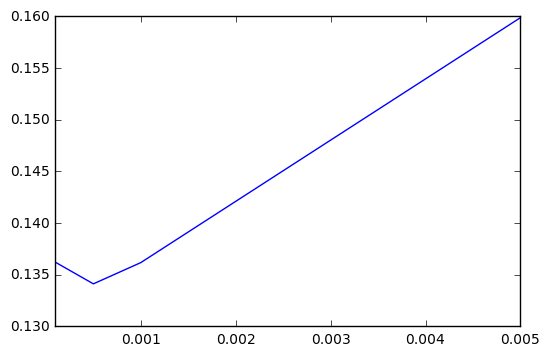

In [160]:
alphas = [1e-4, 5e-4, 1e-3, 5e-3]
cv_lasso = np.array([rmse_cv(Lasso(alpha = alpha, max_iter=50000), X_train, y) for alpha in alphas])
pd.Series(np.sqrt(-cv_lasso), index = alphas).plot()

In [161]:
np.sqrt(-cv_lasso)

array([ 0.13621227,  0.13412216,  0.13618049,  0.1598817 ])

Choose alpha with better score

In [163]:
model_lasso = Lasso(alpha=5e-4, max_iter=50000).fit(X_train, y)

## Getting results##

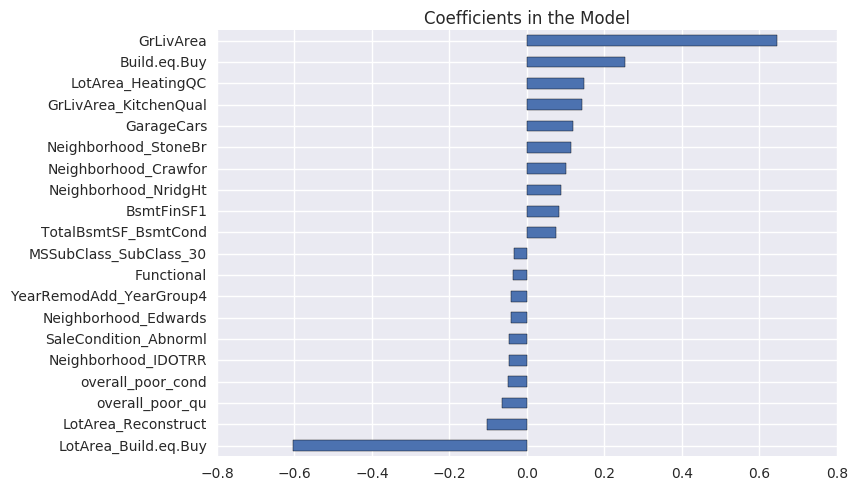

In [165]:
import seaborn as sns
coef = pd.Series(model_lasso.coef_, index = X_train.columns).sort_values()
imp_coef = pd.concat([coef.head(10), coef.tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

Some features still look suspicious. May be, we need to exlude them like RoofMatl_ClyTile and others

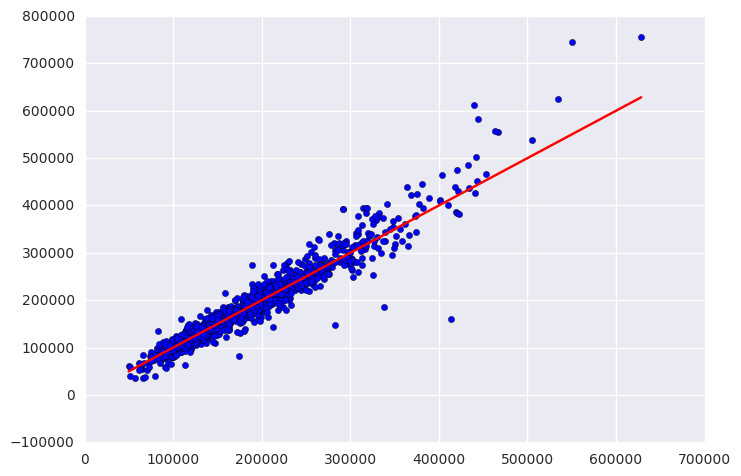

In [166]:
# This is a good way to see how model predict data
p_pred = np.expm1(model_lasso.predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

Some point are far from the red line. May be they are outliers like the 524th and the 1299th

In [35]:
# save to file to make a submission
p = np.expm1(model_lasso.predict(X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("lasso_sol.csv", index = False)

## Model improvement##
With various model tunnings I've got 0.11720 in public leaderboard. Ways of improvement are find some more outliers and exlude (or include) features.